In [1]:
import torch
import torchvision
import sys
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import cv2
import roifile
import glob
import os
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn import linear_model

from common import get_cycle_files, default_base_color_map, default_spot_colors

#### Find and display the first 365 image, from which the spots will be extracted

In [2]:
inputpath = '/Users/akshitapanigrahi/Documents/data/20230616_1652_S0198_0001/raws'
pattern = '*.tif'
file_path_pattern = inputpath + '/' + pattern
filenames = glob.glob(file_path_pattern)

In [3]:
if len(filenames) < 1:
    filenames = glob.glob('*.png')
    
filenames = sorted(filenames)

num = len(filenames)
spot_file = -1

for i in range(num):
    if spot_file == -1 and '_365_' in filenames[i]:
        spot_file = i

num_spots = 0
spot_image = cv2.imread(filenames[spot_file])

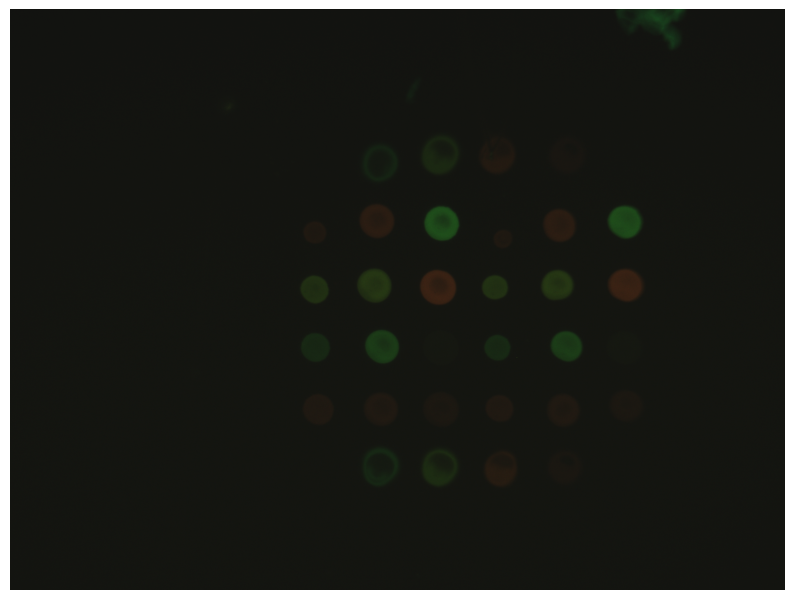

In [4]:
image = cv2.imread(filenames[spot_file])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

#### Load and run SAM model, find all masks

In [5]:
sys.path.append("/segment-anything")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [6]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [7]:
#remove background, sort by area, remove nests
def process_masks(masks):
    #remove background, sort by area, remove nests
    masks = sorted(masks, key=(lambda x: x['area']), reverse=True)
    masks = masks[1:]
    
    points = []
    for mask in masks:
        x = mask['point_coords'][0][0]
        y = mask['point_coords'][0][1]
        points.append((x, y))
    
    valid_points = []
    valid_masks = []
    
    for i in range(len(masks)):
        if points[i] not in valid_points:
            valid_points.append(points[i])
            valid_masks.append(masks[i])
    
    return valid_masks    

In [8]:
def show_anns(anns):
    if len(anns) == 0:
        return
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((anns[0]['segmentation'].shape[0], anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
   
    for ann in anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [1]])
        img[m] = [1, 1, 1, 1]
        #img[m] = color_mask
    ax.imshow(img)

In [9]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_overlap_ratio=0.9,
    crop_n_points_downscale_factor=4,
    min_mask_region_area= 15000,  # Requires open-cv to run post-processing
    output_mode = "binary_mask",
)

In [10]:
masks2 = mask_generator_2.generate(image)

In [11]:
len(masks2)

36

In [12]:
new_masks = process_masks(masks2)

In [13]:
len(new_masks)

35

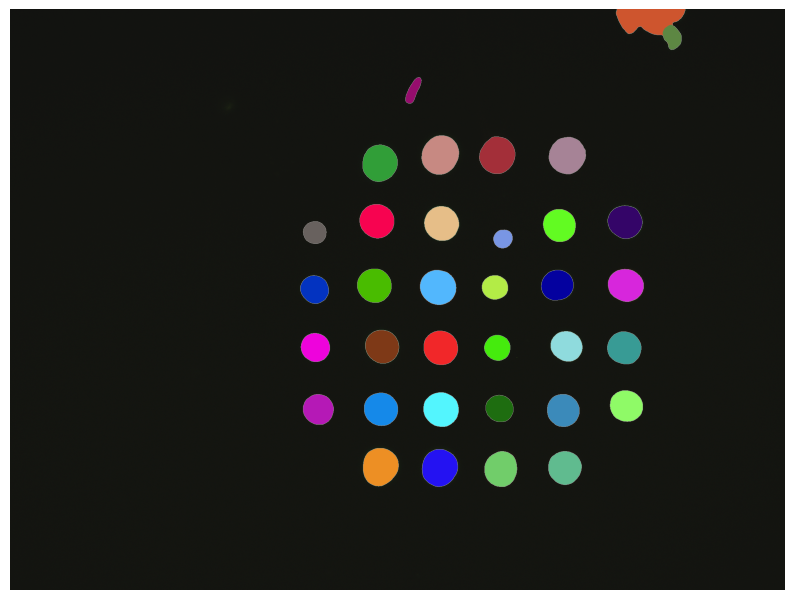

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(new_masks)
plt.axis('off')
plt.show() 

In [15]:
len(new_masks)

35

In [16]:
valid_masks = []
for mask in new_masks:
    array = [mask['bbox'][2], mask['bbox'][3]]
    X = max(array)
    array.remove(X)
    Y = array[0]
    
    if X/Y < 1.1:
        valid_masks.append(mask)

new_masks = valid_masks

In [17]:
len(valid_masks)

32

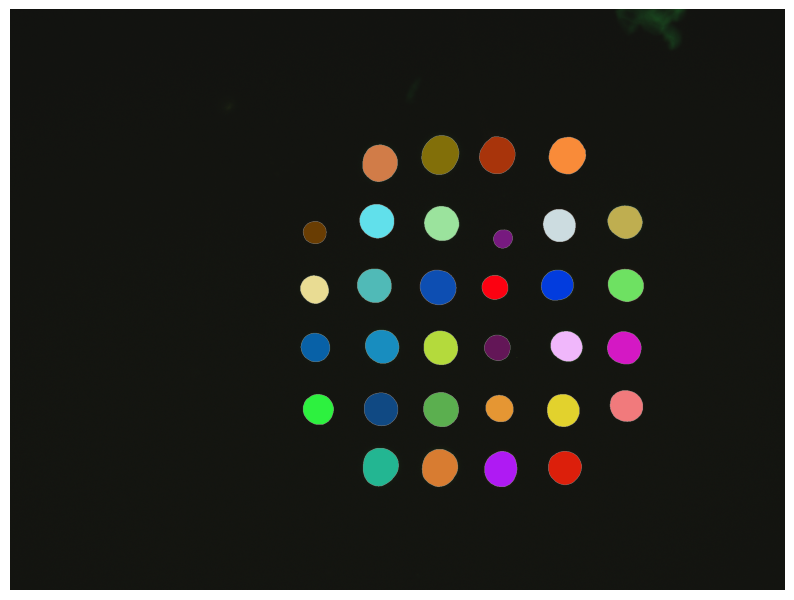

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(new_masks)
plt.axis('off')
plt.show() 

#### Convert each mask to ROI array representation, overlay all masks to form overall ROI image array

In [19]:
#Map pixel value to that ROI's mask array, get sam mask -> returns sam mask and pixel mappings to their indivdual mask array
def get_mask_arr_dict_and_sam_mask(masks):
    pixel_mask_dict = {}
                                   
    mask = np.empty((1520, 2028))
    to_sum = []
                                   
    for i, mask in enumerate(masks):
        pixel_mask_dict[i + 1] = mask['segmentation'].astype(int) * (i + 1)
        to_sum.append(pixel_mask_dict[i + 1])
    
    mask = np.sum(to_sum, axis = 0)
                                   
    return mask, pixel_mask_dict

In [20]:
sam_mask, pixel_mask_dict = get_mask_arr_dict_and_sam_mask(new_masks)

#### Assign ROIs natural numerical ordering

In [21]:
#Get leftmost coordinate of a mask array
def find_roi_leftmost_coord(roi_mask_arr):
    rows, cols = roi_mask_arr.shape
    for i in range(cols):
        for j in range(rows):
            curr = roi_mask_arr[j, i]
            if (curr != 0):
                return (i, j) 

In [22]:
#Define dictionary of pixel value and its left most coordinate
masks_leftmost_mapping = {}

for pixel_val in pixel_mask_dict.keys():
    masks_leftmost_mapping[pixel_val] = find_roi_leftmost_coord(pixel_mask_dict.get(pixel_val))

In [23]:
#Naming

In [24]:
discovered_rois = [] #list of discovered rois
discovered_dict = {} #list of pixel value and its coord of discovery

In [25]:
# Get the dimensions of the array
rows, cols = sam_mask.shape
to_add_curr_row = []

for i in range(rows):
    for j in range(cols):
        curr = sam_mask[i, j]
        if curr != 0 and not(curr in to_add_curr_row) and not(curr in discovered_rois):
            to_add_curr_row.append(curr)
            discovered_dict[curr] = (j, i)
    discovered_rois.extend(to_add_curr_row)
    #print(to_add_curr_row)
    to_add_curr_row = []

In [26]:
pixel_discovery_order_dict = {}

for i, pixel in enumerate(discovered_rois):
    pixel_discovery_order_dict[pixel] = i + 1

In [27]:
def get_ycoords(pixel):
    mask_arr = pixel_mask_dict.get(pixel)
    
    y_coords = []
    
    rows, cols = mask_arr.shape

    for i in range(rows):
        for j in range(cols):
            curr = mask_arr[i, j]
            if curr != 0 and not (i in y_coords):
                y_coords.append(i)
    
    return y_coords

In [28]:
def check_if_two_overlap_row(p_1, p_2):
    y_1 = get_ycoords(p_1)
    y_2 = get_ycoords(p_2)
    
    set_1 = set(y_1)
    set_2 = set(y_2)
    
    if len(set_1.intersection(set_2)) > 0:
        return True
    
    return False

In [29]:
undiscovered_rois = discovered_rois[:]  # Create a shallow copy
ordered_discovered_rois = []

for i in discovered_rois:
    curr_overlap = []
    sorted_curr = []
    
    for j in undiscovered_rois:
        if check_if_two_overlap_row(i, j):
            curr_overlap.append(j)
    
    sorted_curr = sorted(curr_overlap, key=lambda k: masks_leftmost_mapping[k][0])
    ordered_discovered_rois.extend(sorted_curr)
    undiscovered_rois = [ele for ele in undiscovered_rois if ele not in sorted_curr]
    curr_overlap = []

In [30]:
for i, pixel in enumerate(ordered_discovered_rois):
    pixel_discovery_order_dict[pixel] = (i + 1)

In [31]:
pixel_discovery_order_dict

{1: 2,
 5: 3,
 3: 4,
 6: 1,
 11: 6,
 15: 10,
 9: 7,
 20: 9,
 31: 5,
 32: 8,
 13: 12,
 14: 16,
 7: 13,
 23: 15,
 27: 11,
 30: 14,
 17: 18,
 10: 19,
 24: 21,
 19: 22,
 26: 17,
 29: 20,
 22: 28,
 8: 25,
 16: 24,
 25: 23,
 21: 27,
 28: 26,
 2: 29,
 4: 30,
 12: 31,
 18: 32}

In [32]:
roi_ordering = np.zeros(image.shape[:2], dtype=np.uint8)
for i, val in enumerate(discovered_rois):
    text = str(pixel_discovery_order_dict.get(val))
    loc = masks_leftmost_mapping[val]
    roi_ordering = cv2.putText(roi_ordering, text, loc, cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 1, cv2.LINE_AA)

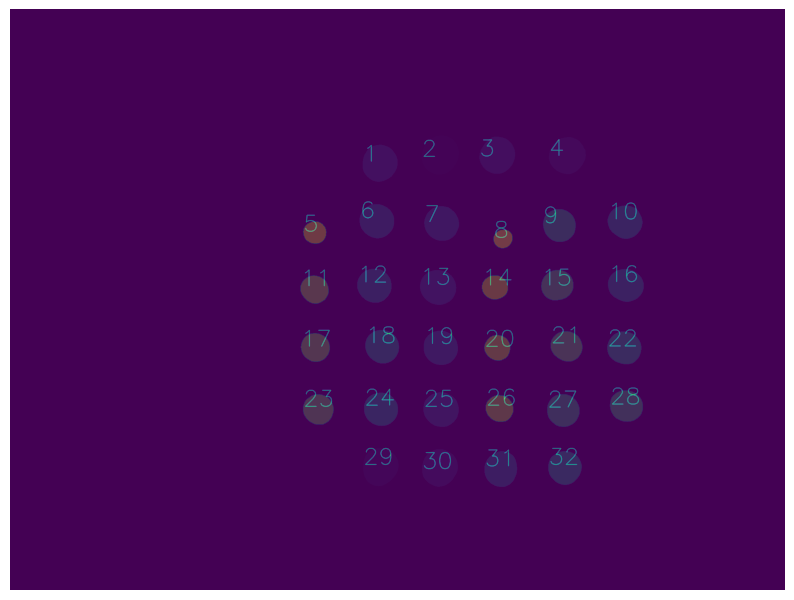

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(sam_mask)
plt.imshow(roi_ordering, alpha = 0.75)
plt.axis('off')
plt.show()

#### Find base spots

In [34]:
#Ask user where A, C, T, G are

In [36]:
bases = ['A', 'C', 'T', 'G']
user_base_spots = []
A = int(input("Which number spot corresponds to base A"))
T = int(input("Which number spot corresponds to base T"))
C = int(input("Which number spot corresponds to base C"))
G = int(input("Which number spot corresponds to base G"))
user_base_spots.extend([A, T, C, G])

Which number spot corresponds to base A5
Which number spot corresponds to base T11
Which number spot corresponds to base C17
Which number spot corresponds to base G23


In [37]:
for key, discovery in pixel_discovery_order_dict.items():
    if discovery in user_base_spots:
        base_index = user_base_spots.index(discovery)
        base = bases[base_index]
        pixel_discovery_order_dict[key] = base

#### Order and name remaining spots

In [39]:
undiscovered_rois = ordered_discovered_rois[:]
undiscovered_rois = [ele for ele in ordered_discovered_rois if pixel_discovery_order_dict.get(ele) not in bases]

In [40]:
for i, spot in enumerate(undiscovered_rois):
    pixel_discovery_order_dict[spot] = i + 1

In [41]:
roi_ordering = np.zeros(image.shape[:2], dtype=np.uint8)
for i, val in enumerate(discovered_rois):
    text = str(pixel_discovery_order_dict.get(val))
    loc = masks_leftmost_mapping[val]
    roi_ordering = cv2.putText(roi_ordering, text, loc, cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 1, cv2.LINE_AA)

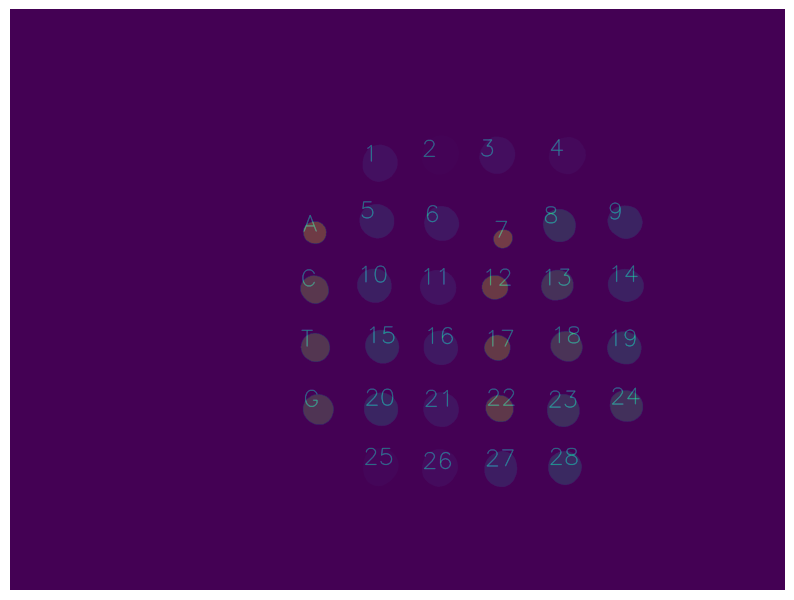

In [42]:
plt.figure(figsize=(10,10))
plt.imshow(sam_mask)
plt.imshow(roi_ordering, alpha = 0.75)
plt.axis('off')
plt.show()